### VoiceMorph: A UNet-based Voice Conversion Model using Audio MNIST Dataset 
#### Group 7 
Milangiri Gauswami (23PGAI0039) <br>
Yogita Patel (23PGAI0091)

In [3]:
%cd '/tf/Speech Processing/Project/AudioMnist'

/tf/Speech Processing/Project/AudioMnist


In [29]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import soundfile as sf
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import Utils.unet_util as uu
import Utils.loss as loss_fn
from tqdm import tqdm
import scipy.io.wavfile as wav
from Utils.read_audio_file import play_audio_file

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


pd.options.display.max_columns = None
%reload_ext autoreload
%autoreload 2

In [98]:
pip install simpleaudio 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-38
      creating build/lib.linux-x86_64-cpython-38/simpleaudio
      copying simpleaudio/__init__.py -> build/lib.linux-x86_64-cpython-38/simpleaudio
      copying simpleaudio/shiny.py -> build/lib.linux-x86_64-cpython-38/simpleaudio
      copying simpleaudio/functionchecks.py -> build/lib.linux-x86_64-cpython-38/simpleaudio
      creating build/lib.linux-x86_64-cpython-38/simpleaudio/test_audio
      copying simpleaudio/test_audio/c.wav -> build/lib.linux-x86_64-cpython-38/simpleaudio/test_audio
      copying simpleaudio/test_audio/e.wav -> build/lib.linux-x86_64-cpython-38/simpleau

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')

# tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# %cd "/content/drive/MyDrive/Colab Notebooks/Speech Processing"

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Testing librosa to load and process audio files

In [30]:
current_wrd = os.getcwd()
dataset_path = os.path.join(current_wrd, 'recordings')
dataset_files = os.listdir(dataset_path)
dataset_files[:5]
# {digitLabel}_{speakerName}_{index}.wav


['0_george_0.wav',
 '0_george_1.wav',
 '0_george_10.wav',
 '0_george_11.wav',
 '0_george_12.wav']

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

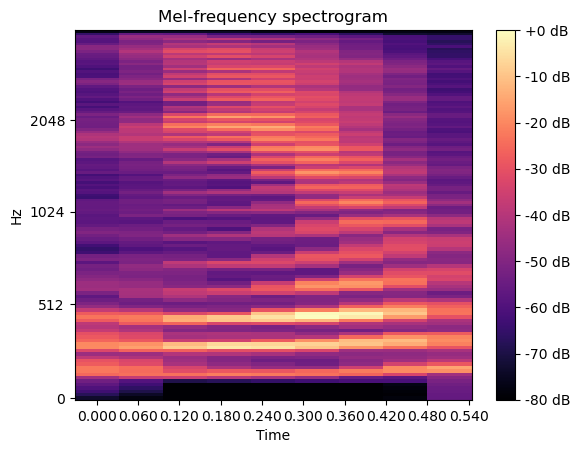

In [31]:
single_file = os.path.join(dataset_path, "0_george_19.wav")

y, sr = librosa.core.load(single_file, sr=8000)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)


fig, ax = plt.subplots()

ref_value = np.max(S)
S_db = librosa.power_to_db(S, ref=ref_value)
img = librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [32]:
S = librosa.db_to_power(S_db, ref=ref_value)
y = librosa.feature.inverse.mel_to_audio(S, sr=sr)
sf.write('reconstructed_audio.wav', y, sr, subtype='PCM_24')

# Loading all the audio files in the dataset

In [33]:
df = pd.DataFrame({"file": dataset_files})
df["S"] = None
df["y"] = None
df["sr"] = None
df["ref_value"] = None
df["S_db"] = None
df["number"] = df["file"].apply(lambda x: x.split("_")[0])
df["speaker"] = df["file"].apply(lambda x: x.split("_")[1])
df["index"] = df["file"].apply(lambda x: x.split("_")[2].split(".")[0])
df["target"] = 0

for i, row in tqdm(df.iterrows(), total=len(df)):
    single_file = os.path.join(dataset_path, row["file"])
    y, sr = librosa.core.load(single_file, sr=8000)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    ref_value = np.max(S)
    S_db = librosa.power_to_db(S, ref=ref_value)
    df.at[i, "S"] = S
    df.at[i, "y"] = y
    df.at[i, "sr"] = sr
    df.at[i, "ref_value"] = ref_value
    df.at[i, "S_db"] = S_db


100%|██████████| 3000/3000 [00:12<00:00, 241.13it/s]


## Removing more than 16 seconds audio
## Padding zeros to make audio 16 seconds for convolution

In [34]:
def resize_zero(x, shape):
    x_shape = x.shape
    x_x = x_shape[0]
    x_y = x_shape[1]
    y_diff = shape[1] - x_y
    x = np.hstack([x, np.zeros([x_x, y_diff])])
    return x

def remove_more_than_shape(x, shape_y):
    x_shape = x.shape
    x_y = x_shape[1]
    if x_y > shape_y:
        return False
    else:
        return True
    
df = df[df["S_db"].apply(lambda x: remove_more_than_shape(x, 16))]
df["S_db_old"] = df["S_db"]
df["S_db"] = df["S_db"].apply(lambda x: resize_zero(x, (128, 16)))

## We are selecting george as target ouput so we map all other speakers to george

In [35]:
df_george = df[df["speaker"] == "george"]
df_george = df_george[df["index"] == "1"]
df_others = df[df["speaker"] != "george"]

In [36]:
def randomly_find_speaker(df, speaker: str, number: str):
    number = str(number)
    df_speaker = df[df["speaker"] == speaker]
    df_speaker = df_speaker[df_speaker["number"] == number]
    return df_speaker["S_db"].sample(1).values[0]


In [37]:
df_others["target"] = df_others.apply(lambda x: randomly_find_speaker(df_george, "george", x["number"]), axis=1)
df_others["target"]

50      [[-61.03742980957031, -66.40101623535156, -78....
51      [[-61.03742980957031, -66.40101623535156, -78....
52      [[-61.03742980957031, -66.40101623535156, -78....
53      [[-61.03742980957031, -66.40101623535156, -78....
54      [[-61.03742980957031, -66.40101623535156, -78....
                              ...                        
2995    [[-57.764286041259766, -63.72462844848633, -74...
2996    [[-57.764286041259766, -63.72462844848633, -74...
2997    [[-57.764286041259766, -63.72462844848633, -74...
2998    [[-57.764286041259766, -63.72462844848633, -74...
2999    [[-57.764286041259766, -63.72462844848633, -74...
Name: target, Length: 2483, dtype: object

In [38]:
df_others["S_db"] = df_others["S_db"].apply(lambda x: np.reshape(x, (128, 16, 1)))
df_others["target"] = df_others["target"].apply(lambda x: np.reshape(x, (128, 16, 1)))

In [39]:
df_others["S_db"].apply(lambda x: x.shape).value_counts()

(128, 16, 1)    2483
Name: S_db, dtype: int64

In [40]:
train_df, test_df = train_test_split(df_others, test_size=0.1)

df_others = train_df

In [41]:
input_values = np.stack(np.array(df_others["S_db"]))
output_values = np.stack(np.array(df_others["target"]))

tf_dataset = tf.data.Dataset.from_tensor_slices((input_values, output_values))

[Text(0.5, 1.0, 'Expected Mel-frequency spectrogram')]

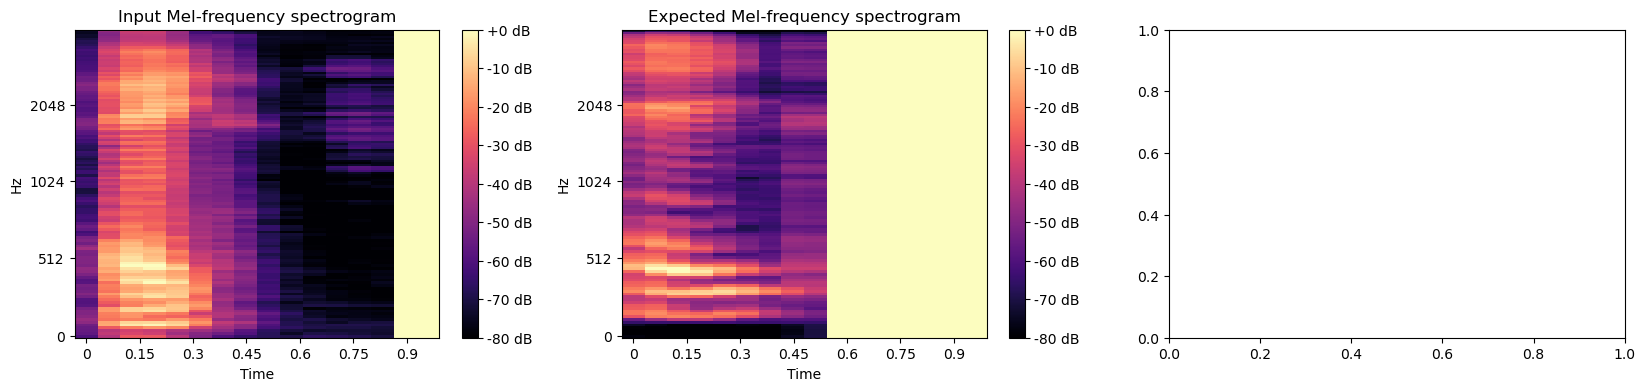

In [47]:
# create 3 plots from 3 differetn S files and compare them to the target

input_S = np.reshape(test_file["S_db"].values[0], (128, 16))
expected_S = np.reshape(test_file["target"].values[0], (128, 16))
predicted_S = np.reshape(test_prediction, (128, 16)) * -1


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

ref_value_input = np.max(input_S)
img_input = librosa.display.specshow(input_S, x_axis='time', y_axis='mel', sr=sr, ax=ax1)
fig.colorbar(img_input, ax=ax1, format='%+2.0f dB')
ax1.set(title='Input Mel-frequency spectrogram')

ref_value_expected = np.max(expected_S)
img_expected = librosa.display.specshow(expected_S, x_axis='time', y_axis='mel', sr=sr, ax=ax2)
fig.colorbar(img_expected, ax=ax2, format='%+2.0f dB')
ax2.set(title='Expected Mel-frequency spectrogram')


In [42]:
BATCH_SIZE = 20
BUFFER_SIZE = 400

IMG_WIDTH = 16
IMG_HEIGHT = 128


num_samples = tf.data.experimental.cardinality(tf_dataset).numpy()

# Define the size of the train and test sets
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

# Shuffle the dataset
tf_dataset = tf_dataset.shuffle(num_samples, seed=42)

# Split the dataset into train and test sets
train_dataset = tf_dataset.take(train_size).batch(BATCH_SIZE)
test_dataset = tf_dataset.skip(train_size).batch(BATCH_SIZE)


input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)

In [18]:

model = uu.unet_generator(
    input_shape=input_shape,
    output_shape=input_shape,
    output_channels=1,
    initial_filter_size=64,
    no_of_layers=3,
    deep_supervision=True
)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
model.compile(optimizer='adam',
              # loss='mean_squared_error',
              loss=loss_fn.unet3p_hybrid_loss,
              metrics=['mean_squared_error'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, mode="min"
)

history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[early_stopping])


Epoch 1/100


2023-03-31 13:00:32.608163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2234,128,16,1]
	 [[{{node Placeholder/_1}}]]
2023-03-31 13:00:38.554727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-03-31 13:00:41.485226: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-31 13:00:41.487091: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this m

89/90 [============================>.] - ETA: 0s - loss: 1.0483 - mean_squared_error: 3098.7764

2023-03-31 13:00:55.969475: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


90/90 [==============================] - ETA: 0s - loss: 1.0479 - mean_squared_error: 3101.5974

2023-03-31 13:00:56.792991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2234,128,16,1]
	 [[{{node Placeholder/_1}}]]


90/90 [==============================] - 27s 102ms/step - loss: 1.0479 - mean_squared_error: 3101.5974 - val_loss: 1.0379 - val_mean_squared_error: 2032.9374
Epoch 2/100
90/90 [==============================] - 4s 50ms/step - loss: 0.8661 - mean_squared_error: 4228.6855 - val_loss: 0.8817 - val_mean_squared_error: 4173.9019
Epoch 3/100
90/90 [==============================] - 4s 50ms/step - loss: 0.7950 - mean_squared_error: 4938.9072 - val_loss: 0.8135 - val_mean_squared_error: 3757.6672
Epoch 4/100
90/90 [==============================] - 5s 50ms/step - loss: 0.7599 - mean_squared_error: 4928.0542 - val_loss: 0.7632 - val_mean_squared_error: 4268.0952
Epoch 5/100
90/90 [==============================] - 4s 50ms/step - loss: 0.7406 - mean_squared_error: 4920.5840 - val_loss: 0.7263 - val_mean_squared_error: 4452.3047
Epoch 6/100
90/90 [==============================] - 4s 50ms/step - loss: 0.7285 - mean_squared_error: 4896.4336 - val_loss: 0.7278 - val_mean_squared_error: 4844.4380
Ep

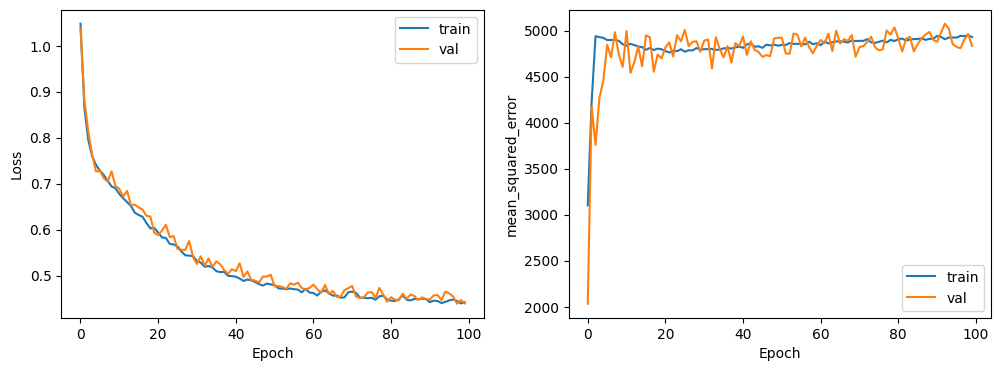

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot the loss
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# plot the accuracy
ax2.plot(history.history['mean_squared_error'], label='train')
ax2.plot(history.history['val_mean_squared_error'], label='val')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('mean_squared_error')
ax2.legend()

plt.show()

In [27]:
model.save("model.h5")


NameError: name 'model' is not defined

### Try to predict the audio file

In [44]:
model = tf.keras.saving.load_model("model.h5", custom_objects={"unet3p_hybrid_loss": loss_fn.unet3p_hybrid_loss})

predictions = model.predict(test_dataset)
predictions.shape


23/23 [==============================] - 6s 246ms/step


(447, 128, 16, 1)

## Testing model on a single audio file from test dataset
###  and comparing the predicted output with the actual output

In [45]:
test_file = test_df.iloc[1:2]
test_data = np.stack(np.array(test_file["S_db"]))
test_tensor = tf.convert_to_tensor(test_data)

test_prediction = model.predict(test_tensor)
test_prediction = np.reshape(test_prediction, (1, 128, 16))
test_prediction = np.reshape(test_prediction, (128, 16))
test_prediction.shape

1/1 [==============================] - 0s 213ms/step


(128, 16)

In [46]:
def remove_zeros(input_db):
    input_db = np.abs(input_db)
    zero_id = 0
    for i in range(input_db.shape[-1]):
        avg_value = input_db[:, i].mean()
        # print(avg_value)
        if avg_value < 10:
            zero_id = i
            break

    input_db = input_db[:, :zero_id]
    input_db = input_db * -1
    return input_db


## Compare the predicted output with the actual output

In [68]:
"8_lucas_14.wav"

,file,S,y,sr,ref_value,S_db,number,speaker,index,target,S_db_old
2506,8_lucas_14.wav,"[[0.00015631704, 0.013979801, 0.21439293, 0.21...","[9.1552734e-05, -0.00012207031, 0.00012207031,...",8000,171.10582,"[[[-60.39258575439453], [-40.87763977050781], ...",8,lucas,14,"[[[-77.86767578125], [-79.42915344238281], [-8...","[[-60.392586, -40.87764, -29.020542, -29.03719..."


[Text(0.5, 1.0, 'Predicted Mel-frequency spectrogram')]

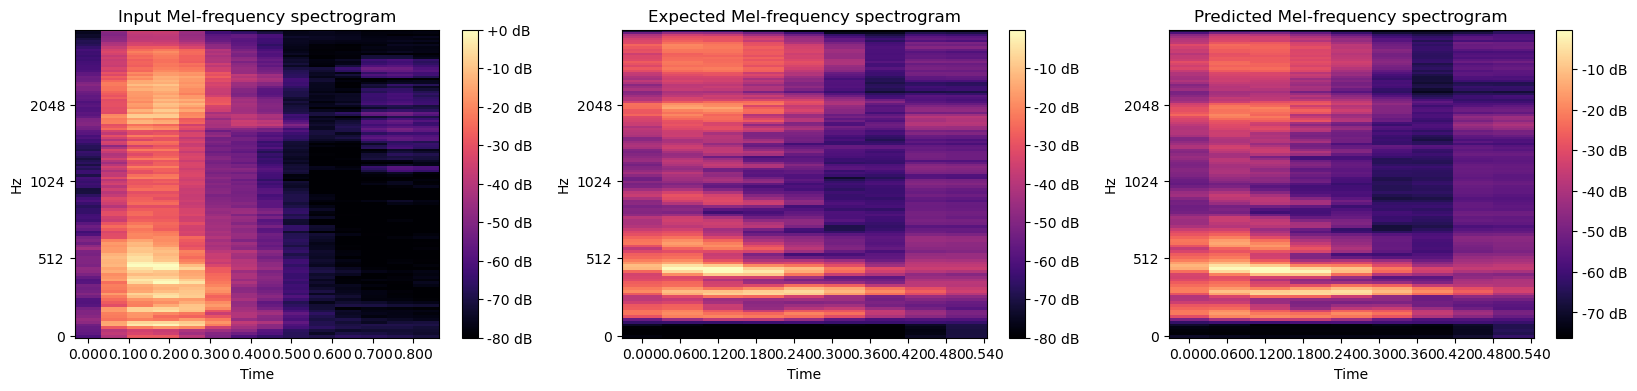

In [56]:
# create 3 plots from 3 differetn S files and compare them to the target

input_S = np.reshape(test_file["S_db"].values[0], (128, 16))
expected_S = np.reshape(test_file["target"].values[0], (128, 16))
predicted_S = np.reshape(test_prediction, (128, 16)) * -1

input_S = remove_zeros(input_S)
expected_S = remove_zeros(expected_S)
predicted_S = remove_zeros(predicted_S)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

ref_value_input = np.max(input_S)
img_input = librosa.display.specshow(input_S, x_axis='time', y_axis='mel', sr=sr, ax=ax1)
fig.colorbar(img_input, ax=ax1, format='%+2.0f dB')
ax1.set(title='Input Mel-frequency spectrogram')

ref_value_expected = np.max(expected_S)
img_expected = librosa.display.specshow(expected_S, x_axis='time', y_axis='mel', sr=sr, ax=ax2)
fig.colorbar(img_expected, ax=ax2, format='%+2.0f dB')
ax2.set(title='Expected Mel-frequency spectrogram')

ref_value_predicted = np.max(predicted_S)
img_predicted = librosa.display.specshow(predicted_S, x_axis='time', y_axis='mel', sr=sr, ax=ax3)
fig.colorbar(img_predicted, ax=ax3, format='%+2.0f dB')
ax3.set(title='Predicted Mel-frequency spectrogram')


# Save output file and original file to compare

In [70]:
sr = 8000
n_fftn_fft = 2048
S = librosa.db_to_power(predicted_S)
power_spec = librosa.db_to_power(predicted_S)
reconstructed_audio = librosa.feature.inverse.mel_to_audio(power_spec, sr=sr)
# wav.write('reconstructed_audio.wav', sr, y_hat)
sf.write('reconstructed_audio.wav', reconstructed_audio, sr)

# Regeneting Expected
S = librosa.db_to_power(expected_S)
power_spec = librosa.db_to_power(expected_S)
expected_audio = librosa.feature.inverse.mel_to_audio(power_spec, sr=sr)
# wav.write('reconstructed_audio.wav', sr, y_hat)
sf.write('expected_audio.wav', reconstructed_audio, sr)


# Origin Input file
original_file = os.path.join(dataset_path, test_file["file"].values[0])
shutil.copy2(original_file, "original_audio.wav")

'original_audio.wav'

In [72]:
# Play Original File
play_audio_file("original_audio.wav", volume=0.7)

In [75]:
# Play Expected File
play_audio_file("expected_audio.wav", volume=10)

In [74]:
# Play Predicted File
play_audio_file("reconstructed_audio.wav", volume=10)